# Overfitting  
Quelle: [tensorlfow.org](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=en)

In [1]:
import tensorflow as tf

from tensorflow.keras import layers, regularizers

print(tf.__version__)

2.5.0-dev20210218


In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [6]:
FEATURES = 28

In [7]:
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type="GZIP")

In [8]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


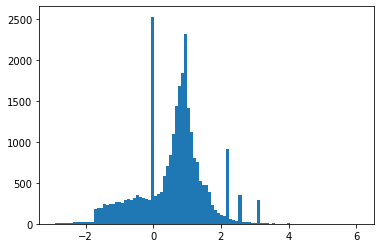

In [10]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [12]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [14]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

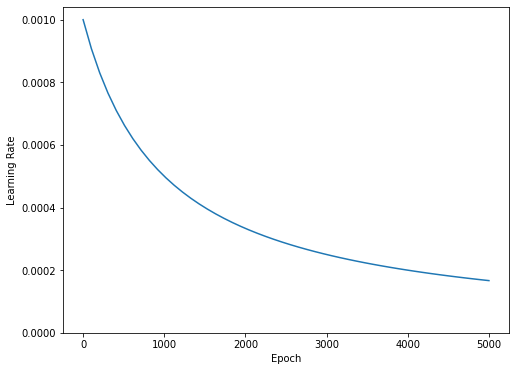

In [17]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
_ = plt.ylabel("Learning Rate")

In [18]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor="val_binary_crossentropy", patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [19]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=[
                        tf.keras.losses.BinaryCrossentropy(from_logits=True, name="binary_crossentropy"),
                        "accuracy"])
    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch= STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [20]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation="elu", input_shape=(FEATURES, )),
    layers.Dense(1)
])

In [21]:
size_histories = {}

In [22]:
size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5095,  binary_crossentropy:0.7345,  loss:0.7345,  val_accuracy:0.4970,  val_binary_crossentropy:0.7145,  val_loss:0.7145,  
....................................................................................................
Epoch: 100, accuracy:0.6073,  binary_crossentropy:0.6252,  loss:0.6252,  val_accuracy:0.5970,  val_binary_crossentropy:0.6270,  val_loss:0.6270,  
....................................................................................................
Epoch: 200, accuracy:0.63

(0.5, 0.7)

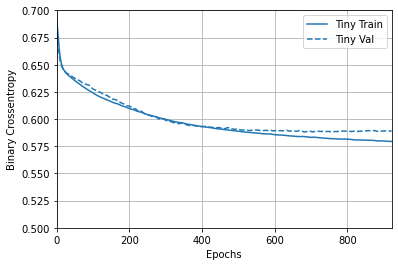

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric= "binary_crossentropy", smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [24]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
    layers.Dense(16, activation="elu"),
    layers.Dense(1)
])

In [25]:
size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4929,  binary_crossentropy:0.7342,  loss:0.7342,  val_accuracy:0.4650,  val_binary_crossentropy:0.7117,  val_loss:0.7117,  
....................................................................................................
Epoch: 100, accuracy:0.6186,  binary_crossentropy:0.6160,  loss:0.6160,  val_accuracy:0.6150,  val_binary_crossentropy:0.6194,  val_loss:0.

In [26]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation="elu", input_shape=(FEATURES,)),
    layers.Dense(64, activation="elu"),
    layers.Dense(64, activation="elu"),
    layers.Dense(1)
])

In [27]:
size_histories["Medium"] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4954,  binary_crossentropy:0.6932,  loss:0.6932,  val_accuracy:0.4710,  val_binary_crossentropy:0.6812,  val_loss:0.6812,  
....................................................................................................
E

In [28]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation="elu", input_shape=(FEATURES, )),
    layers.Dense(512, activation="elu"),
    layers.Dense(512, activation="elu"),
    layers.Dense(512, activation="elu"),
    layers.Dense(1)
])

In [29]:
size_histories["large"] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5138,  binary_crossentropy:0.8335,  loss:0.8335,  val_accuracy:0.4680,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

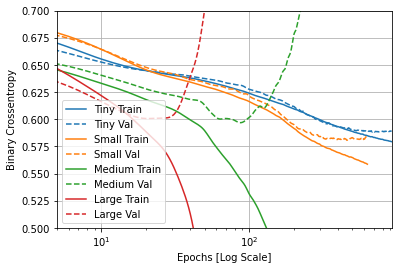

In [30]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [31]:
%load_ext tensorboard

%tensorboard --logdir {logdir}/sizes

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-02-22 15:20:21.239691: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "/home/julius/tensorflow/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/julius/tensorflow/lib/python3.8/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/home/julius/tensorflow/lib/python3.8/site-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/home/julius/tensorflow/lib/python3.8/site-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/home/julius/tensorflow/lib/python3.8/site-packages/tensorboard/program.py", line 258, in main
    return runner(self.flags) or 0
  File "/home/julius/tensorflow/lib/python3.8/site-packages/tensorboard/program.py", line 274, in _run_se

In [32]:
shutil.rmtree(logdir/"regularizers/Tiny", ignore_errors=True)
shutil.copytree(logdir/"sizes/Tiny", logdir/"regularizers/Tiny")

PosixPath('/tmp/tmp2r2we7wb/tensorboard_logs/regularizers/Tiny')

In [33]:
regularizer_histories = {}
regularizer_histories["Tiny"] = size_histories["Tiny"]

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES, )),
    layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories["l2"] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5178,  binary_crossentropy:0.8208,  loss:2.3398,  val_accuracy:0.4640,  val_binary_crossentr

(0.5, 0.7)

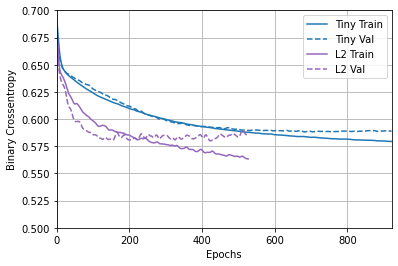

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [36]:
result = l2_model(features)
regularization_loss = tf.add_n(l2_model.losses)

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation="elu", input_shape=(FEATURES, )),
    layers.Dropout(0.5),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories["dropout"] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

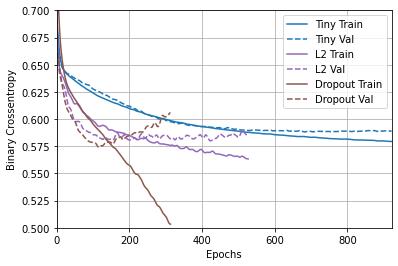

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [39]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="elu", input_shape=(FEATURES, )),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories["combined"] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

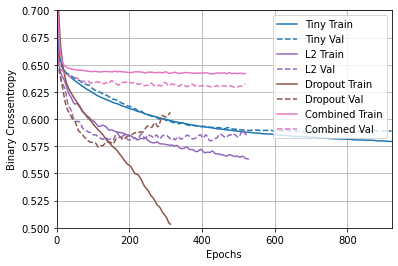

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [41]:
%tensorboard --logdir {logdir}/regularizers

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-02-22 16:07:17.518963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "/home/julius/tensorflow/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/julius/tensorflow/lib/python3.8/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/home/julius/tensorflow/lib/python3.8/site-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/home/julius/tensorflow/lib/python3.8/site-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/home/julius/tensorflow/lib/python3.8/site-packages/tensorboard/program.py", line 258, in main
    return runner(self.flags) or 0
  File "/home/julius/tensorflow/lib/python3.8/site-packages/tensorboard/program.py", line 274, in _run_se